# Gaussian Discriminative Analysis

In here we continue with the probabilistic methods of Machine Learning. Please recall that we are trying the estimate the conditional probability

$$P(X=x|Y=y)$$

where $X$ represents our data or features and $Y$ is the  class label. Using Bayes theorem we can then infer the "inverted" conditional probability

$$P(Y=y|X=x)=
\frac{P(X=x|Y=y)P(Y=y)}
{\sum_y P(X=x|Y=y)P(Y=y)}$$

This is the probability that examplar $x$  belongs to class $y$. This probability can be then used to construct a classifier by suitable thresholding. 

If $X$ is a categorical variable with finite support, we can list all the probabilities. In case of continous  features we have to bin the data or use some parametrized distribution. The most widely used distribution is of course the Normal (Gaussian) distribution. We have already used  it  in our "sex  from height and weight" example. So far we have only used the one dimensional distribution, fitting separately height and weight (or rather BMI). In this notebook we will try to estimate the joint height-weight conditional probability distribution directly. 

We will start by loading the data (we will use the same [kaggle dataset](https://www.kaggle.com/mustafaali96/weight-height)) and converting it to metric units

### Height & weight dataset 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,8]
import pandas as pd

In [3]:
data = pd.read_csv('../../Data/HeightWeight/weight-height.csv')

In [4]:
inch = 0.01 * 2.54 # m
pound = 0.453 # kg

In [5]:
data['Height'] = data['Height'] *inch 
data['Weight'] = data['Weight'] *pound

As always we will split the data into training and testing sets

In [6]:
from sklearn.model_selection import  train_test_split

In [7]:
#by fixing the seed we guarantee that we can split the set in same way each time
#this maybe handy for debuging purposes
seed = 77678 
train_data, test_data  = train_test_split(data,test_size=0.25, random_state=seed)

In [8]:
train_data_F = train_data[train_data.Gender=='Female']
train_data_M = train_data[train_data.Gender=='Male']
print("train ", len(train_data_F), len(train_data_M))
test_data_F = test_data[test_data.Gender=='Female']
test_data_M = test_data[test_data.Gender=='Male']
print("test  ", len(test_data_F), len(test_data_M))

train  3763 3737
test   1237 1263


We see that the classes (gender) are balanced  across the training and testig sets.

In [9]:
# setting colors for consistency throughout the notebook you can subsitute here your favorite "gender colors" :) 
f_color = 'blue'
m_color ='orange'
color = 'grey'

The distribution for each gender looks as follows on scatter plot

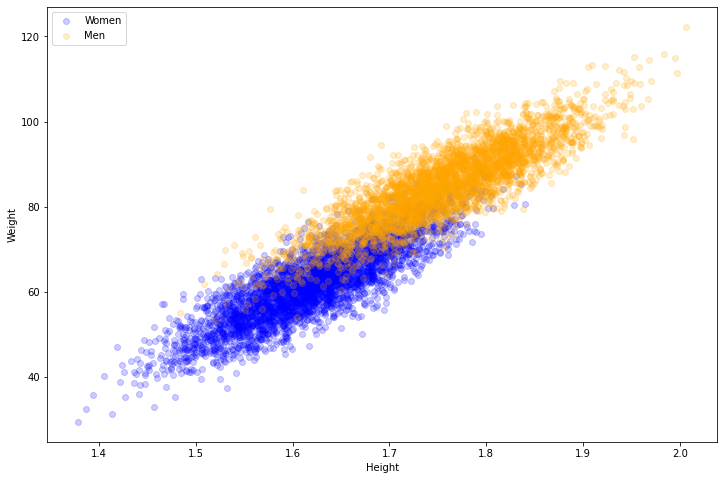

In [10]:
plt.scatter(train_data_F.Height, train_data_F.Weight, alpha=0.2, c = f_color, label='Women');
plt.scatter(train_data_M.Height, train_data_M.Weight, alpha=0.2, c = m_color, label='Men');
plt.legend();
plt.xlabel('Height')
plt.ylabel('Weight');

and on histograms

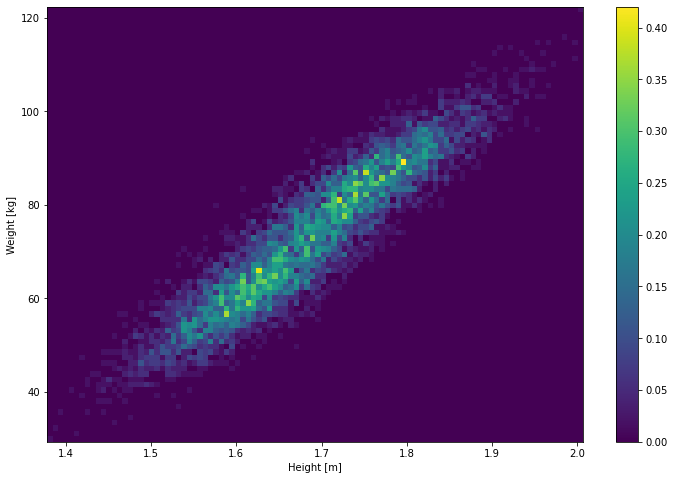

In [11]:
fig, ax = plt.subplots()
ax.set_xlabel('Height [m]');
ax.set_ylabel('Weight [kg]');
hb = ax.hist2d(train_data['Height'], train_data['Weight'], bins=[100,80], density=True);
fig.colorbar(hb[3], ax=ax);

Sometimes we can get a better looking picture with hexagonal bins:

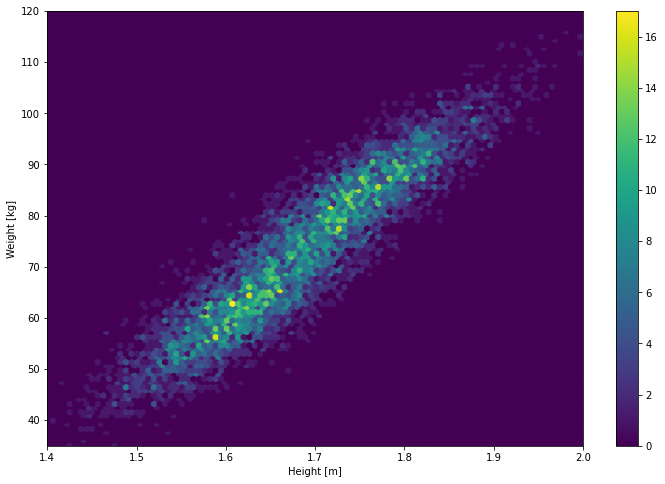

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel('Height [m]')
ax.set_ylabel('Weight [kg]')
hb = ax.hexbin(train_data['Height'], train_data['Weight']);
fig.colorbar(hb);
ax.set_xlim(1.4,2.0);
ax.set_ylim(35,120);

Because we will be using those plots often, for convenience I have wrapped them in few functions below

In [13]:
def hw_plot(**kwargs):
    fig, ax = plt.subplots()
    ax.set_xlabel('Height [m]')
    ax.set_ylabel('Weight [kg]')
    return fig,ax

def hw_scatter(fig,ax, F, M):
    ax.scatter(F.Height, F.Weight, alpha=0.2, c = f_color, label='Women');
    ax.scatter(M.Height, M.Weight, alpha=0.2, c = m_color, label='Men');
    ax.legend();

def hw_hist(fig, ax, df):
    hb = ax.hist2d(train_data['Height'], train_data['Weight'], bins=[100,80], density=True);
    fig.colorbar(hb[3], ax=ax);
    return hb

def hw_hexbin(fig, ax, df, **kwargs):
    hb = ax.hexbin(df['Height'], df['Weight'], **kwargs);
    fig.colorbar(hb);
    return hb

We would like to find the joint probability density function: 

$$P(h,w|S=s)$$

which we will assume is a _multivariate gaussian distribution_:

$$P(\mathbf{x}|S=s)\sim \mathcal{N}(\mu_s,\Sigma_s)$$

The probability density function of this distribution in $D$ dimensions  is given by the formula:

$$\newcommand{\b}[1]{\mathbf{#1}}$$
$$P(\mathbf{x}|\b\mu,\b\Sigma)=
\frac{1}{(2\pi)^{D/2}|\mathbf\Sigma|^{1/2}}
e^{\displaystyle-\frac{1}{2}\left(\mathbf{x}-\b\mu\right)^T\mathbf{\Sigma}^{-1}\left(\mathbf{x}-\b\mu\right)}
$$

$\mathbf{x}$ and $\mathbf{\mu}$ are $D$-dimensional vectors $\mathbf{\mu}$ being the mean or the center of the distribution. $\mathbf{\Sigma}$ is $D\times D$ dimensional symmetric _covariance_ matrix. $|\b\Sigma|$ denotes the _determinant_ of the matrix. 

#### Question How many parameters does the model have?

$\mathbf{\mu}$ nas $D$ parameters and a symmetric matrix  has $(D^2-D)/2+D=D(D+1)/2$ parameters giving altogether $D(D+3)/2$ parameters.

### MLE estimate of multivariate gaussian parameters

Let $\b X$  be $N\times D$ the measurement matrix. Each row is a $D$ dimensional vector of measurements $\b X_i$. Assumimg that all measurments come from the Multivariate  Gaussian distribution with parameters $\b\mu$ and  $\Sigma$ the likelihood is

$$\prod_{i=1}^N P(\b X_i|\b\mu,\b\Sigma)$$

and the log likelihood is: 

$$\sum_{i=1}^N \log P(\b X_i|\b\mu,\b\Sigma) =  
- N \frac{1}{2}\log |\Sigma| -\sum_{i=1}^N\frac{1}{2}\left(\mathbf{X_i}-\mu\right)^T\mathbf{\Sigma}^{-1}\left(\mathbf{X_i}-\mu\right) + const$$

the last term can be rewritten as

$$\newcommand{\tr}{\operatorname{Tr}}$$
$$
\frac{1}{2}\sum_{i=1}^N\sum_{j,k=1}^D
\left(X_{ik}-\mu_k\right)
\left(X_{ij}-\mu_j\right)
\left(\b{\Sigma}^{-1}\right)_{jk}
=\frac{N}{2}\tr \b C \,\b\Sigma^{-1} 
$$

where $\b C$ is $D \times D$  empirical covariance matrix

$$C_{kj}=\frac{1}{N}\sum_{i}\left(X_{ik}-\mu_k\right)\left(X_{ij}-\mu_j\right)$$

$$\tr \b A\equiv \sum_{i=1}^{D} A_{ii}$$

$\tr$ is the _trace_ operator (the sum of the elements on the diagonal):

To compute the MLE estimates we have to differentiate this expression with respect to $\b \mu$ and $\Sigma$. Let's start with $\b \mu$. The likelihood depends on $\mu$ only trough the matrix $\b C$

$$\frac{\partial}{\partial \mu_m}C_{jk}
=\frac{1}{N}\sum_{i}\frac{\partial}{\partial \mu_m}\left(X_{ij}-\mu_j\right)\left(X_{ik}-\mu_k\right)
=-\frac{1}{N}\sum_{i}\left(\delta_{m,j}\left(X_{ik}-\mu_k\right) + \delta_{m,k}\left(X_{ij}-\mu_j\right)\right)
$$ 

$$\frac{\partial}{\partial \mu_m}C_{jk}=-\delta_{m,j}\left(\overline{ x}_{k}-\mu_k\right) - \delta_{m,k}\left(\overline{ x}_j-\mu_j\right)$$

$$\frac{1}{2}\frac{\partial}{\partial \mu_m}\left(\tr \b C \,\b\Sigma^{-1}\right) = 
\frac{1}{2}\left(\frac{\partial}{\partial \mu_m}\tr \b C\right) \,\b\Sigma^{-1} = 
-\frac{1}{2}\sum_{jk}
\left(
\delta_{m,j}\left(\overline{ x}_{k}+\mu_k\right) - \delta_{m,k}\left(\overline{ x}_j-\mu_j\right))
\right)
\left(\b\Sigma^{-1}\right)_{kj}=-\sum_{k}\left(\b\Sigma^{-1}\right)_{mk}\left(\overline{ x}_{k}+\mu_k\right)
$$

where we have used the fact that $\Sigma$ is a symmetric matrix. Or in vector notation

$$\frac{1}{2}\frac{\partial}{\partial \b \mu}\tr \b C \,\b\Sigma^{-1} = -\b\Sigma^{-1}(\b x -\b \mu)$$

Assuming thar $\b\Sigma^{-1}$ is not singular, the solution to 

$$\b\Sigma^{-1}(\overline{\b x} -\b \mu)=0$$

equation is unsurprisingly 

$$\b \mu = \overline{\b x}$$

The differentiation with respect to $\b\Sigma$ is more difficult and instead we will look for the inverse matrix $\b A= \b\Sigma^{-1}$.  Because the determinant of the inverse matrix is the inverse of the determinant the expression we have to minimize is  

$$\frac{1}{2}\log |\b A|-\frac{1}{2}\tr \b C \,\b A$$

Differentiating with respect to element $A_{kl}$ we obtain

$$\frac{1}{2}\frac{\partial}{\partial A_{kl}}\log |\b A|-\frac{1}{2}\frac{\partial}{\partial A_{kl}}\tr \b C \,\b A 
=
\frac{1}{2}\frac{\partial}{\partial A_{kl}}\log |\b A|-\frac{1}{2}C_{lk}
$$

#### Problem 

Show that 

$$\frac{\partial}{\partial A_{kl}}\log |\b A|  = \left({\b A}^{-1}\right)_{lk}$$

__Hint__ Use the Laplace expansion of the determinant. 

Using the above expression we obtain finally the equation for MLE of $\b A$

$$ \left({\b A}^{-1}\right)_{lk}\equiv \Sigma_{lk}=C_{lk}$$

So the  again unsurprisingly the covariance matrix is approximated by its empirical value. This estimatiom runs into severe problems in higher dimension but for the moment we can use it "as is" for our classifier. Below are two helper functions to calculate those estimators and to construct a corresponing distribution object. 

$$\mu = \bar{\mathbf{x}}\qquad \Sigma_{lk}=C_{lk}$$

In [14]:
def gaussian_stats(X):
    mu = np.mean(X,0)
    sigma = np.cov(X,rowvar=False)
    return mu, sigma

def mv_gaussian_mle_fit(X):
    mu, sigma = gaussian_stats(X)
    return st.multivariate_normal(mu, sigma)

In two dimensions we can visualise the distribution by drawing the countour lines. For multivariate gaussian those are ellipses. I have included a function to plot 
ellipses of given radius expressed in units of standard deviation $\sigma$. It is adapted from [Plot a confidence ellipse of a two-dimensional dataset](https://matplotlib.org/3.2.1/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py)  and described [here](https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html). If you have cloned my repo you can use it by importing the `plotting` module from `mchlearn` package as follows:

In [15]:
import sys
sys.path.append("../../") #need to add main repo directory to the system path used for searching packages
from mchlearn.plotting import confidence_ellipse

In [16]:
mu_F, cov_F = gaussian_stats(train_data_F[['Height', 'Weight']])
mu_M, cov_M = gaussian_stats(train_data_M[['Height', 'Weight']])

By default ellipsed are drawn with a three $\sigma$ radius

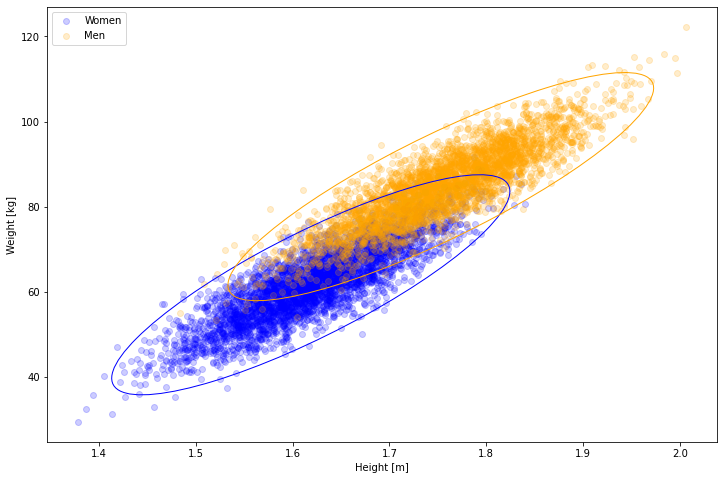

In [17]:
fig, ax = hw_plot()
hw_scatter(fig, ax, train_data_F, train_data_M)
confidence_ellipse(mu_F, cov_F, ax, edgecolor = f_color)
confidence_ellipse(mu_M, cov_M, ax, edgecolor = m_color);

### Fitting the class priors

Actually our model has some more parameters: those are the _a priori_ probabilities of each class. We can either set them "by hand" as we did before:

In [18]:
p_F = 0.5
p_M = 1- p_F

Or we can fit them from the data using MLE using the joint probability distribution both on labels $y_i$ and features $\b X_i$

$$P(\b X,\b y| \theta) = \prod_{i=1}^N  P(\b X_i|\b\mu_{y_i},\b\Sigma_{y_i})\pi_{y_i}$$

Here $\theta$ denotes all parameter of the model: $\mu$, $\Sigma$  and prior $\pi$ for each class.  The log likehood is 

$$\sum_{i=1}^N \left(\log \pi_{y_i} +\log P(\b X_i|\b\mu_{y_i},\b\Sigma_{y_i}) \right) = 
\sum_c N_c \log \pi_c +\sum_c \sum_{i:y_i=c}\log P(\b X_i|\b\mu_{y_i},\b\Sigma_{y_i}) $$

$N_c$ denotes the number of samples in each class. For the last term we proceed as before fitting $\b\mu$ and $\b\Sigma$ for each class. The priors require slightly more caution. We cannot just differentiate with respect to  priors $\pi_c$ because the priors are not independent as their sum must be equal one.  We will have to use the [Lagrange multipliers method](https://en.wikipedia.org/wiki/Lagrange_multiplier).  What we differentiate is the expression

$$\sum_c N_c \log \pi_c+\lambda \sum_c \pi_c$$ 

Differentiating with respect to $\pi_d$ leads to equation

$$\frac{N_c}{\pi_c}+\lambda =0\quad\text{or}\quad \pi_c = -\frac{N_c}{\lambda}$$

Adjustig $\lambda$ as to fulfill the constraint gives us the final answer

$$\pi_c = \frac{N_c}{N}$$

### Classification

Once we have the distributions in each class and class priors  we can finally calculate the probability of a person being a woman by Bayes theorem:

$$P(S=f|h,w) = \frac{P(h,w|S=f) P(S=f)}{P(h,w|S=f) P(S=f)+P(h,w|S=m) P(S=m)}$$

In [19]:
dist_F = mv_gaussian_mle_fit(train_data_F[['Height', 'Weight']])
dist_M = mv_gaussian_mle_fit(train_data_M[['Height', 'Weight']])

In [20]:
def prob_F_cond_HW(hw):
    pf = dist_F.pdf(hw)*p_F
    pm = dist_M.pdf(hw)*p_M
    return pf/(pf+pm)

We then calculate all the usuall metrics

In [21]:
test_predicted_proba_gda = prob_F_cond_HW(test_data[['Height','Weight']])

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

In [23]:
pd.DataFrame(confusion_matrix(test_data.Gender=='Female', test_predicted_proba_gda>0.5, normalize='true'))

,0,1
0,0.916073,0.083927
1,0.084883,0.915117


In [24]:
pd.DataFrame({0: ['TNR', 'FPR'], 1: ['FPR','TPR']})

,0,1
0,TNR,FPR
1,FPR,TPR


In [25]:
from mchlearn.plotting import roc_plot

In [26]:
def add_roc_curve(fig, ax, y_true, y_score, name):
    fprs, tprs, thds = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    ax.plot(fprs, tprs, label="{:s}  {:5.3f}".format(name, auc));
    return fprs, tprs, thds, auc

DataFrame is used only for "pretty printing". The true labels correspond to rows and predicted to columns. The normalisation set to  'true' mean that the numbers in each row add up to one. So the matrix above corresponds to

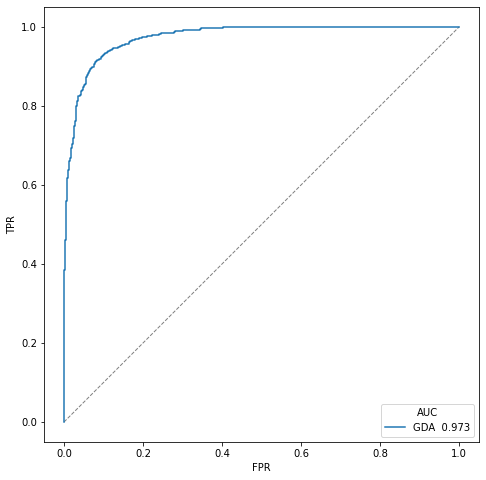

In [27]:
fig, ax = roc_plot()
add_roc_curve(fig, ax, test_data.Gender=='Female', test_predicted_proba_gda, "GDA")
ax.legend(title='AUC');

If you look back at our Naive Bayes Height-BMI classfier you can see that the performance is almost identical. 

### Decision boundaries

To get an insight into the working of this classifier we will look at the decisions boundaries: lines or surfaces separating the regions of $R^D$ corresponding to each class.  E.g. in our example this will be the line defined by equation

$$P(F|h,w)=\frac{1}{2}$$

In [28]:
from mchlearn.plotting import grid

In [29]:
hs = np.linspace(1.3, 2.1,100)
ws = np.linspace(30,120, 100)

To visualize this boundary I will draw the countour line(s) of $P(F|h,w)$. This  is slightly technical  and I have provided a function that generates the data
suitable to be used directly in the matplotlib `contour`  and `contourf` functions.  Those functions can be found in the `plotting` module in the `mchlearn` package. 

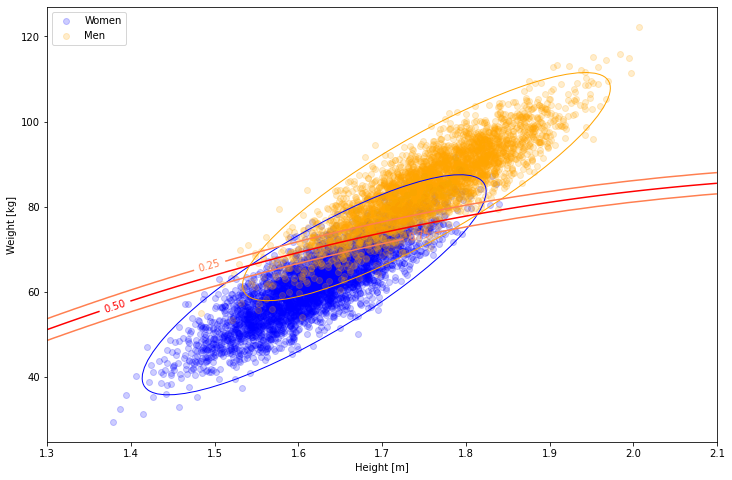

In [30]:
fig, ax = hw_plot()
hw_scatter(fig, ax, train_data_F, train_data_M)
confidence_ellipse(mu_F, cov_F, ax, edgecolor = f_color)
confidence_ellipse(mu_M, cov_M, ax, edgecolor = m_color)
cs = ax.contour(*grid(hs,ws,prob_F_cond_HW), [0.25, 0.5, 0.75], colors=['coral','red', 'coral']);
ax.clabel(cs);

I have included boundaries for three different thresholds. Here is the same picture but using the histogram instead of scatter plot

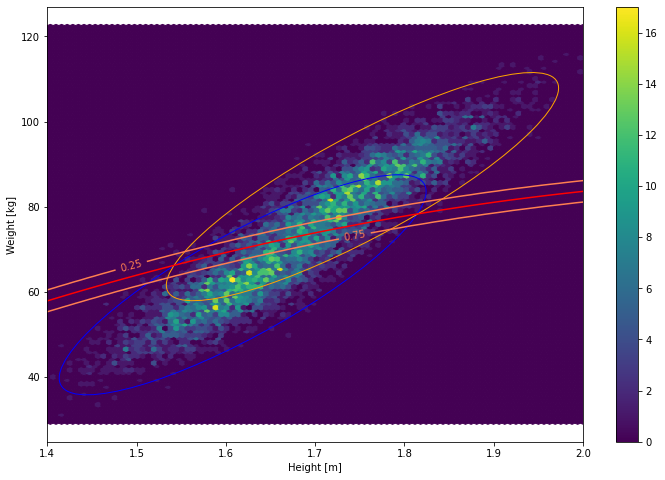

In [31]:
fig, ax = hw_plot()
hw_hexbin(fig,ax, train_data)
ax.set_xlim(1.4,2.0)
confidence_ellipse(mu_F, cov_F, ax, edgecolor = f_color)
confidence_ellipse(mu_M, cov_M, ax, edgecolor = m_color)
cs = ax.contour(*grid(hs,ws,prob_F_cond_HW), [0.25, 0.5, 0.75], colors=['coral','red', 'coral']);
ax.clabel(cs);

## Quadratic Discriminant Analysis

As you can see the decision boundary is not a straight line. Actually we can show that this is a quadratic curve. 

 A quadratic surface is a ensemble of all points $\b x$ such that

$$F(\b x) = 0$$

and function $F$ is a polynomial of degree at most two in the coordinates of the vector $x$. In two dimension this can be an ellipse, a parabola, a hyperbola, two intersecting lines and parallel lines.  E.g. the ellipse is given by the equation:

$$a x_1^2 +b x_2^2-c = 0,\qquad a,b,c > 0$$

#### Problem 

Give the equation for two intersecting lines and two parallel lines. 

__Hint__ The line is defined by equation

$$a x_1+ b x_2 -d =0$$

In general case of more then two classes  the decision boundary between classes is a piecewise quadratic surface. More specifically, a decision boundary between any two classes is a quadratic surface. That's why this method is called _Quadratic Discriminant Analysis_. 

To show this let's write again the conditional class probability:

$$P(Y=c|X=x)=\frac{P(X=x|Y=c)\pi_c}{\sum_c P(X=x|Y=c)\pi_c}$$

Assuming the usuall majority rule the classifier will return the class with the bigest probability. Because the denominator  does not depend on $c$ this is same as picking biggest of all $P(X=x|Y=c)\pi_c$. That is classifier picks class $c$ iff

$$ P(X=x|Y=c)\pi_c > P(X=x|Y=c')\pi_{c'}, \text{ for all } c'\neq c$$

This defines a region that is a intersection of $K-1$ regions defined by a single inequality  $P(X=x|Y=c)\pi_c > P(X=x|Y=c')\pi_{c'}$. The boundary of this region is defined by the equality

$$P(X=x|Y=c)\pi_c = P(X=x|Y=c')\pi_{c'}$$

Plugging in the multivariate gaussian distribution we obtain equation

$$
\frac{\pi_c}{(2\pi)^{D/2}|\b\Sigma_c|^{1/2}}
e^{\displaystyle-\frac{1}{2}\left(\mathbf{x}-\b\mu_c\right)^T{\b\Sigma_c}^{-1}\left(\mathbf{x}-\b\mu_c\right)}
=
\frac{\pi_{c'}}{(2\pi)^{D/2}|\b\Sigma_{c'}|^{1/2}}
e^{\displaystyle-\frac{1}{2}\left(\mathbf{x}-\b\mu_{c'}\right)^T{\b\Sigma_{c'}}^{-1}\left(\mathbf{x}-\b\mu_{c'}\right)}
$$

Taking the logarithm of both sides and droping common terms we obtain

$$
\log\pi_c-
\frac{1}{2}\log|\b\Sigma_c|^{1/2}
-\frac{1}{2}\left(\mathbf{x}-\b\mu_c\right)^T{\b\Sigma_c}^{-1}\left(\mathbf{x}-\b\mu_c\right)
=
\log\pi_{c'}-\frac{1}{2}\log |\b\Sigma_{c'}|^{1/2}
-\frac{1}{2}\left(\mathbf{x}-\b\mu_{c'}\right)^T{\b\Sigma_{c'}}^{-1}\left(\mathbf{x}-\b\mu_{c'}\right)$$

Which is a quadratic equation in $\b x$.  So the final region is an intersection of regions with quadratic boundaries, so its boundary is piecewise quadratic. 

## Naive Bayes

In our case we had ample data to fit the distributions. Each distribution requires five parameters so we have ten parameters in  total but the training set contains few thousands examples. Moreover  the classes are balanced. However the number of parameters grows quadratically with the number of dimensions. One (brutal) way of  reducing the number of parameters is to consider only the _diagonal_ $\b\Sigma$ matrices. This mean that we treat all features as conditionally independent so this is just Naive Bayes we have already considered.  We will redo this example here but this time  with  height and weight.  Those variables  are evidently correlated, this will enable us to see more clearly what kind of approximations we are making. We will also use the functions supplied in the scikit-learn library instead of constructing the classifier "by hand".

$$\Sigma_c = \begin{pmatrix}
\sigma_{c0}^2 & 0&\ldots  & 0 & 0\\
0  & \sigma_{c1}^2&\ldots  & 0 & 0\\
\vdots & \vdots & \ddots & \vdots & \vdots\\
0& 0 & \ldots &  \sigma^2_{c(n-2)} & 0\\
0& 0 & \ldots &  0 & \sigma^2_{c(n-1)}
\end{pmatrix}
$$

In [32]:
from sklearn.naive_bayes import GaussianNB

In [33]:
nb_cls = GaussianNB()

In [34]:
nb_cls.fit(train_data[['Height', 'Weight']], train_data.Gender=='Female')

GaussianNB()

In [35]:
# The standard classifiers in sklearn return probabilities for all the classes. 
# In case of binary classifier we need only one. 
test_predicted_proba_nb = nb_cls.predict_proba(test_data[['Height', 'Weight']])[:,1] 

In [36]:
pd.DataFrame(confusion_matrix(test_data.Gender=='Female', test_predicted_proba_nb>0.5, normalize='true')) 

,0,1
0,0.884402,0.115598
1,0.105093,0.894907


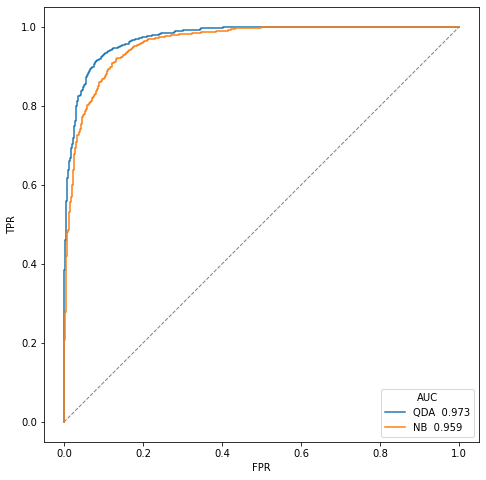

In [37]:
fig, ax = roc_plot()
add_roc_curve(fig,ax, test_data.Gender=='Female', test_predicted_proba_gda, "QDA")
add_roc_curve(fig,ax, test_data.Gender=='Female', test_predicted_proba_nb, "NB")
ax.legend(title='AUC')

The performance  of this classifer is not that much worse! Let's look at the fitted distributions and the decision boundary

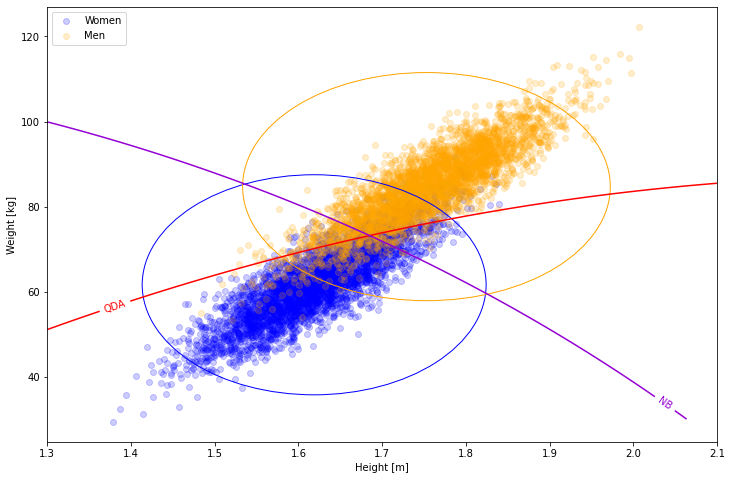

In [38]:
fig, ax = hw_plot()
hw_scatter(fig,ax,train_data_F, train_data_M)
confidence_ellipse(nb_cls.theta_[1], np.diag(nb_cls.sigma_[1]), ax, edgecolor = f_color)
confidence_ellipse(nb_cls.theta_[0], np.diag(nb_cls.sigma_[0]), ax, edgecolor = m_color)
cs_qda = ax.contour(*grid(hs,ws,prob_F_cond_HW),  levels=[0.5], colors=['red']);
ax.clabel(cs_qda,[0.5], fmt="QDA");
cs_nb = ax.contour(*grid(hs,ws,lambda a: nb_cls.predict_proba(a)[:,1]), levels=[0.5], colors=['darkviolet']);
ax.clabel(cs_nb,[0.5], fmt="NB");

We can see that the distributions are wide off the mark. Naive Bayes has constrained them to be ellipses parallel to the axes.  The decision boundary is also different, but it manages to separate clearly the centers of the clusters from each other. And that's where most of the samples are. This can be better seen on the histogram

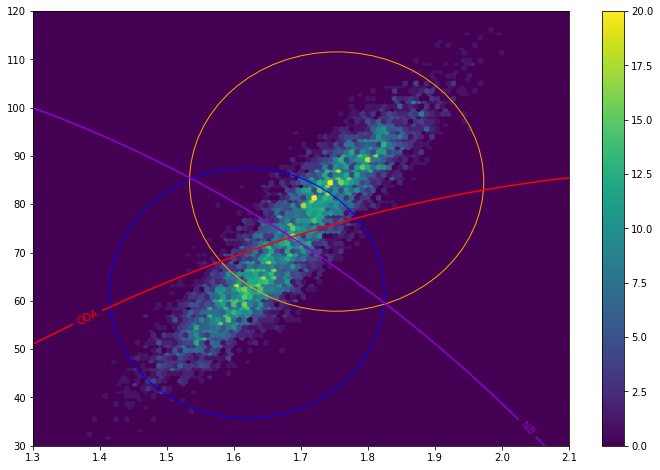

In [39]:
fig, ax = plt.subplots()
hw_hexbin(fig,ax, train_data, extent=(1.3,2.1,30, 120))
confidence_ellipse(nb_cls.theta_[1], np.diag(nb_cls.sigma_[1]), ax, edgecolor = f_color)
confidence_ellipse(nb_cls.theta_[0], np.diag(nb_cls.sigma_[0]), ax, edgecolor = m_color)
cs_qda = ax.contour(*grid(hs,ws,prob_F_cond_HW),  levels=[0.5], colors=['red']);
ax.clabel(cs_qda,[0.5], fmt="QDA");
cs_nb = ax.contour(*grid(hs,ws,lambda a: nb_cls.predict_proba(a)[:,1]), levels=[0.5], colors=['darkviolet']);
ax.clabel(cs_nb,[0.5], fmt="NB");

The violet line also clearly separates the two peaks which explains not so bad performance of the classifier. 

## Linear Discriminative Analysis

Another way of reducing the number of parameters is to fit  only one common $\b\Sigma$ matrix. That's we assume that all the classes have similar "shape" and differ only by the localisation of centers. 

$$\Sigma_c = \Sigma,\quad c=0,\ldots,n-1$$

#### Problem

 Show that in this case decisions boundaries are straight lines. 

Because of this property This approach is called _Linear Discriminative Analysis_ and you have already encountered it on previous lectures. 
Let's try it out on our dataset. 

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [41]:
lda_cls = LinearDiscriminantAnalysis(store_covariance=True) # we will need the covariance matrix later for illustrative purposes. 

In [42]:
lda_cls.fit(train_data[['Height', 'Weight']], train_data.Gender=='Female')

LinearDiscriminantAnalysis(store_covariance=True)

In [43]:
test_predicted_proba_lda = lda_cls.predict_proba(test_data[['Height', 'Weight']])[:,1]

In [44]:
pd.DataFrame(confusion_matrix(test_data.Gender=='Female', test_predicted_proba_lda>0.5, normalize='true'))

,0,1
0,0.912906,0.087094
1,0.083266,0.916734


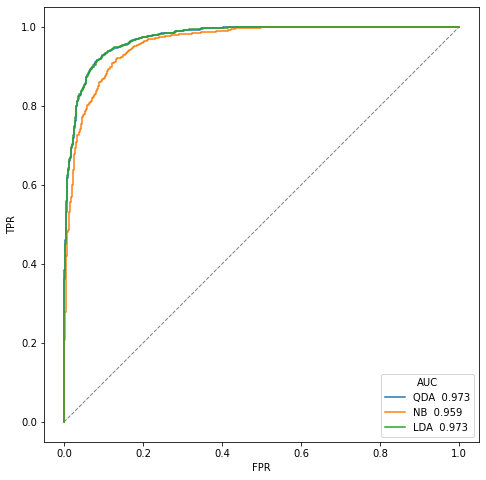

In [45]:
fig, ax = roc_plot()
add_roc_curve(fig,ax, test_data.Gender=='Female', test_predicted_proba_gda, "QDA")
add_roc_curve(fig,ax, test_data.Gender=='Female', test_predicted_proba_nb, "NB")
add_roc_curve(fig,ax, test_data.Gender=='Female', test_predicted_proba_lda, "LDA")
ax.legend(title='AUC');

The performance of this classifier is undistinguishable from performance of the Quadratic Discriminator.  This is because the two distributions have roughly same shape so the approximation is valid.

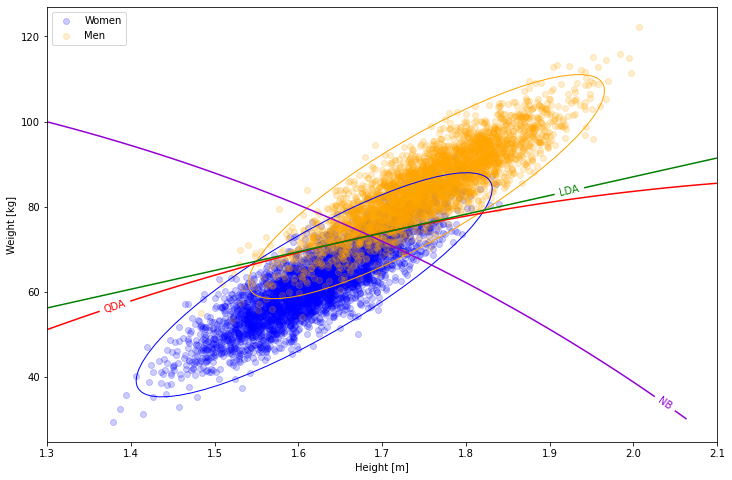

In [46]:
fig, ax = hw_plot()
hw_scatter(fig,ax, train_data_F, train_data_M)
confidence_ellipse(nb_cls.theta_[1], lda_cls.covariance_, ax, edgecolor = f_color)
confidence_ellipse(nb_cls.theta_[0], lda_cls.covariance_, ax, edgecolor = m_color)
cs_qda = ax.contour(*grid(hs,ws,prob_F_cond_HW),  levels=[0.5], colors=['red']);
ax.clabel(cs_qda,[0.5], fmt="QDA");
cs_nb = ax.contour(*grid(hs,ws,lambda a: nb_cls.predict_proba(a)[:,1]), levels=[0.5], colors=['darkviolet']);
ax.clabel(cs_nb,[0.5], fmt="NB");
cs_lda = ax.contour(*grid(hs,ws,lambda a: lda_cls.predict_proba(a)[:,1]), [0.5], colors=['green']);
ax.clabel(cs_lda,[0.5], fmt="LDA");

As you can see the LDA decision boundary (that indeed is a straight line) is very close to quadratic boundary in the region of interest.

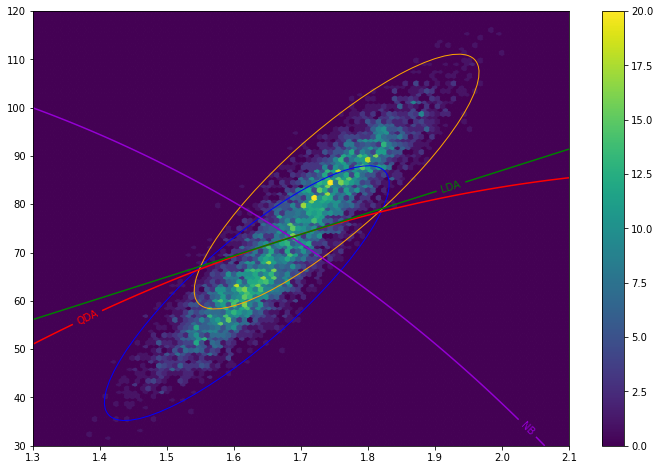

In [47]:
fig, ax = plt.subplots()
hw_hexbin(fig, ax, train_data, extent=(1.3, 2.1, 30, 120))
confidence_ellipse(nb_cls.theta_[1], lda_cls.covariance_, ax, edgecolor = f_color)
confidence_ellipse(nb_cls.theta_[0], lda_cls.covariance_, ax, edgecolor = m_color)
cs_qda = ax.contour(*grid(hs,ws,prob_F_cond_HW),  levels=[0.5], colors=['red']);
ax.clabel(cs_qda,[0.5], fmt="QDA");
cs_nb = ax.contour(*grid(hs,ws,lambda a: nb_cls.predict_proba(a)[:,1]), levels=[0.5], colors=['darkviolet']);
ax.clabel(cs_nb,[0.5], fmt="NB");
cs_lda = ax.contour(*grid(hs,ws,lambda a: lda_cls.predict_proba(a)[:,1]), [0.5], colors=['green']);
ax.clabel(cs_lda,[0.5], fmt="LDA");